# Hồi quy Gamma sử dụng R

## Lê Ngọc Khả Nhi


# Giới thiệu

Trong nghiên cứu y học, phần lớn các đại lượng mà ta khảo sát là biến liên tục, dương và thường có phân phối bất đối xứng. Trong khi đó, những phương pháp thống kê cơ bản mà sinh viên được dạy như t test hay ANOVA đều dựa trên giả định phân phối chuẩn (Gaussian). Đa số nghiên cứu sinh sử dụng một cách máy móc 1 loại kiểm định (thí dụ t test) và bỏ qua bước kiểm tra đặc tính phân bố của dữ liệu. Cách làm này có thể dẫn đến sai lầm trong suy diễn và/hoặc tiên lượng.

Ngay cả khi kết quả phản nghiệm bằng p_values có vẻ hợp lý, việc sử dụng giả định phân bố sai vẫn là nguy cơ tiềm ẩn cho sai lầm về tiên lượng hay ước tính hiệu ứng - thí dụ đơn giản nhất : phân phối chuẩn cho phép biến số ngẫu nhiên dao động tự do trên tập R,do đó một mô hình hồi quy tuyến tính có thể cho ra kết quả âm hoặc quá cao, trái với tự nhiên.

Mặt khác, nếu cẩn trọng hơn và phát hiện ra vấn đề dữ liệu phân phối lệch, các bạn cũng không có nhiều lựa chọn: những cách làm thông thường là hoán chuyển logarit hoặc dùng kiểm định phi tham số chỉ mang tính đối phó về kỹ thuật nhưng không phải là giải pháp tối ưu.

Trong bài thực hành này, Nhi muốn giới thiệu một giải pháp hiệu quả và phổ quát cho suy diễn thống kê trên dữ liệu là biến liên tục và có phân phối lệch dương, đó là mô hình hồi quy tuyến tính với phân bố gamma.

# Bước 1: Chuẩn bị dữ liệu

Chúng ta bắt đầu câu chuyện bằng một bài toán suy diễn thống kê đơn giản : so sánh nồng độ bilirubin giữa 2 nhóm bệnh nhân mắc bệnh Viêm gan : nhóm thứ nhất bệnh nhẹ hơn và sống sót, nhóm thứ hai nặng hơn và đã tử vong; dựa theo bộ dữ liệu “hepatitis”.

Nhi tải dữ liệu từ database openml.org, sau khi loại bỏ missing values,giản lược chúng ta có 149 cases, gồm 119 trường hợp sống sót và 30 trường hợp tử vong. Biến kết quả là BILIRUBIN, phân nhóm là Class

In [2]:
library(tidyverse)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.3.2     v purrr   0.3.2
v tibble  3.0.3     v dplyr   1.0.0
v tidyr   1.1.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [3]:
df = read_csv("https://www.openml.org/data/get_csv/55/dataset_55_hepatitis.csv",na = '?')

df<-df%>%dplyr::select(Class,BILIRUBIN)%>%na.omit()

df$Class = recode(df$Class, `DIE` = "G2_Die", `LIVE` = "G1_Live")

tail(df,10)

Parsed with column specification:
cols(
  .default = col_character(),
  AGE = col_double(),
  BILIRUBIN = col_double(),
  ALK_PHOSPHATE = col_double(),
  SGOT = col_double(),
  ALBUMIN = col_double(),
  PROTIME = col_double()
)
See spec(...) for full column specifications.


Class,BILIRUBIN
G1_Live,1.2
G2_Die,4.2
G2_Die,1.7
G1_Live,0.9
G1_Live,0.6
G2_Die,7.6
G1_Live,0.9
G1_Live,0.8
G1_Live,1.5
G2_Die,1.2


# Bước 2: mô tả đặc tính phân bố:

Tiếp theo, Nhi sử dụng các hàm của package dplyr và e1071 để làm một thống kê mô tả cho biến BILIRUBIN ở từng phân nhóm. Các trị số được tính bao gồm arithmetic mean, median, SD, Skewness, kurtosis, Min và Max

In [8]:
df%>%group_by(Class)%>%
summarise_at('BILIRUBIN', funs(n = length(.),
                               Mean=mean,
                               Median=median,
                                  SD=sd,
                                  Skew = e1071::skewness(.),
                                  Kurt = e1071::kurtosis(.),
                                  Min=min,
                                  Max=max
                              ))

Warning message:
"funs() is soft deprecated as of dplyr 0.8.0
please use list() instead

# Before:
funs(name = f(.)

# After: 
list(name = ~f(.))
This warning is displayed once per session."

Class,n,Mean,Median,SD,Skew,Kurt,Min,Max
G1_Live,119,1.146218,1.00,0.7221425,2.726613,8.567268,0.3,4.6
G2_Die,30,2.543333,1.95,1.9400824,1.266140,1.032473,0.4,8.0


Như ta thấy, Bilirubin (như các đại lượng sinh học khác), có giá trị dương (>0), liên tục và phân phối bất đối xứng (lệch dương).Thang đo của bilirubin trong dữ liệu từ 0.3 đến 8 đơn vị. Hình ảnh phân bố ở mỗi phân nhóm có thể được khảo sát trực quan bằng KDE plot như sau:

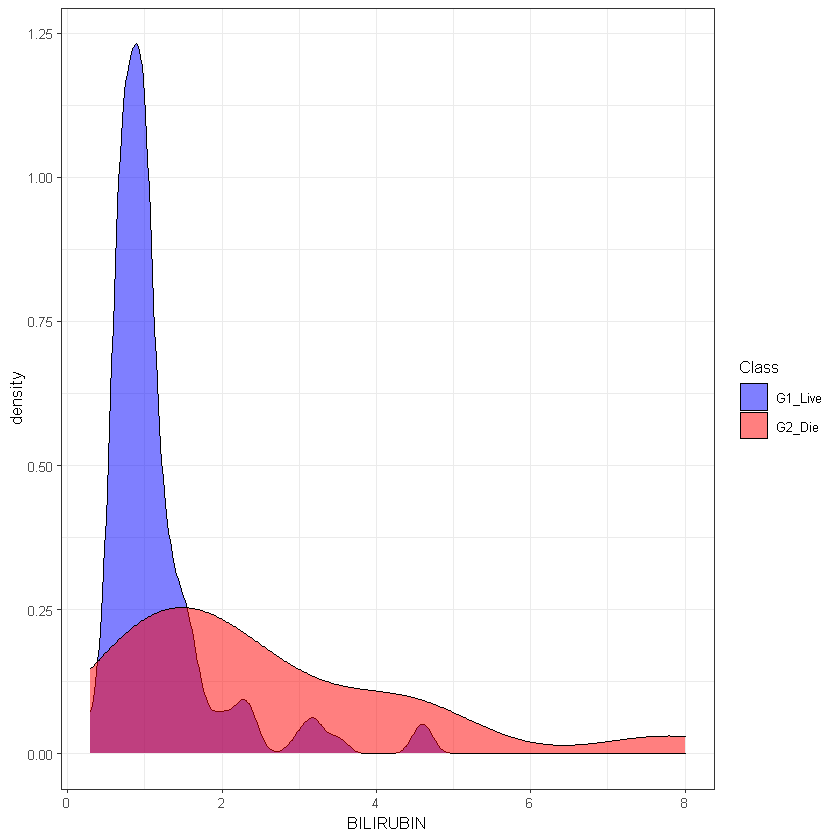

In [9]:
df%>%ggplot()+
  geom_density(aes(x=BILIRUBIN,fill=Class),alpha=0.5)+
  scale_fill_manual(values=c("blue","red"))+
  theme_bw(10)

Một chi tiết khác là phân bố của bilirubin hoàn toàn khác biệt (không đồng dạng) giữa 2 phân nhóm, có nghĩa là kiểm định phi tham số như Mann_Whitney U không cho phép chúng ta suy diễn về khác biệt trung vị, mà chỉ có thể suy diễn sự khác biệt chung chung về loại phân phối.

Như đã trình bày ở trên, hoán chuyển logarit là một giải pháp thông dụng để đối phó với phân phối lệch dương, sau khi hoán chuyển, phân phối mới trở nên khá đối xứng và gần với phân phối Gaussian, tuy nhiên ta mất đi ý nghĩa của thang đo gốc:

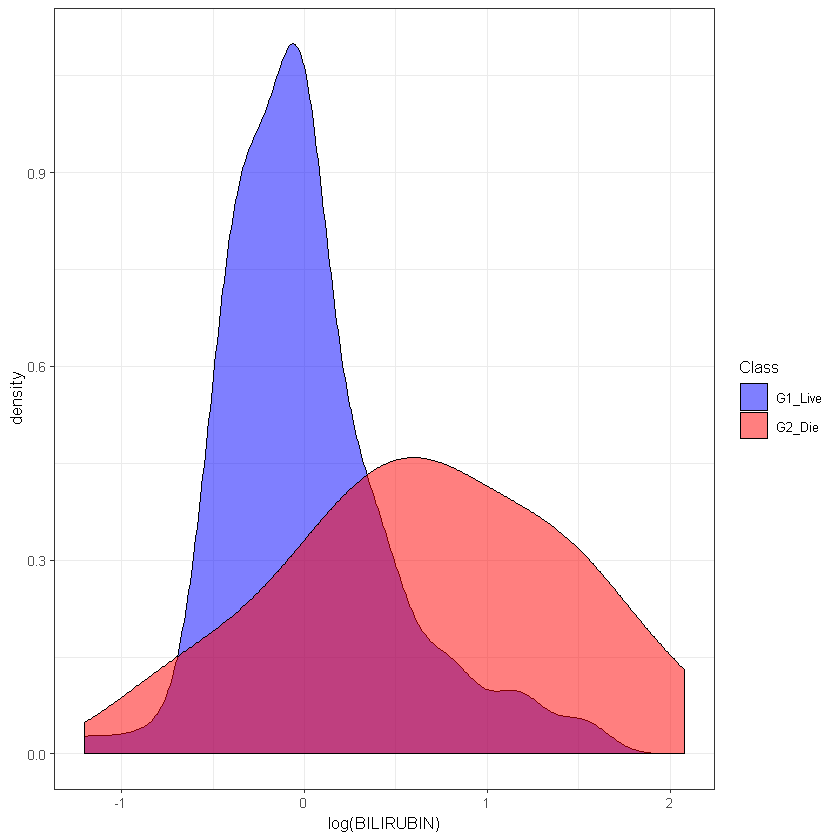

In [36]:
df%>%ggplot()+
  geom_density(aes(x=log(BILIRUBIN),fill=Class),alpha=0.5)+
  scale_fill_manual(values=c("blue","red"))+
  theme_bw(10)

# Bước 3: Suy diễn thống kê

Một kiểm định t trên dữ liệu hoán chuyển logarit thường đủ cho việc suy diễn thống kê về so sánh hơn/kém giữa 2 phân nhóm, tuy nhiên do thang đo gốc không còn nữa, ta chỉ có thể ước tính hiệu ứng khác biệt trên thang đo mới là log(bilirubin):

In [10]:
t.test(log(df$BILIRUBIN) ~ df$Class)


	Welch Two Sample t-test

data:  log(df$BILIRUBIN) by df$Class
t = -4.4108, df = 34.413, p-value = 9.636e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.9487554 -0.3504332
sample estimates:
mean in group G1_Live  mean in group G2_Die 
           0.01132794            0.66092224 


Thay vì dùng kiểm định t, chúng ta có thể dùng mô hình hồi quy tuyến tính để suy diễn thống kê, với nhiều ưu điểm hơn như tính phổ quát và cho nhiều thông tin hơn.

Để thích nghi mô hình tuyến tính với dữ liệu biến kết quả lệch dương như hiện thời, chúng ta có nhiều giải pháp, thí dụ:

Hoán chuyển logarit cho biến kết quả trước khi đưa vào mô hình

In [11]:
library(jtools)

lm(log(BILIRUBIN) ~ Class-1, data = df)%>%
  summ(confint = TRUE, digits = 3)

Warning message:
"package 'jtools' was built under R version 3.6.3"

MODEL INFO:
Observations: 149
Dependent Variable: log(BILIRUBIN)
Type: OLS linear regression 

MODEL FIT:
F(2,147) = 22.657, p = 0.000
R² = 0.236
Adj. R² = 0.225 

Standard errors: OLS
------------------------------------------------------------
                      Est.     2.5%   97.5%   t val.       p
------------------ ------- -------- ------- -------- -------
ClassG1_Live         0.011   -0.086   0.109    0.230   0.819
ClassG2_Die          0.661    0.467   0.855    6.728   0.000
------------------------------------------------------------

Khi làm theo cách này, ta có 2 hướng diễn giải hiệu ứng của phân nhóm G2 (tử vong): hoặc dùng trực tiếp hệ số hồi quy (0.661) làm tăng trung bình (arithmetic mean) trên thang đo log(Y), hoặc sự thay đổi tỉ lệ thuận geometric mean của Y theo mean ratio = exp(0.661), trên thang đo nguyên thủy.

$E[log(Y_i)] = \beta_0 + \beta_1X_1$

Thí dụ ta có thể diễn giải: bệnh nhân ở phân nhóm tử vong có bilirubin cao hơn 1.94 lần so với phân nhóm sống sót, tức là geometric mean của bilirubin ở các bệnh nhân tử vong ước tính khoảng 1.96 đơn vị

Kết quả tiên lượng này không chính xác, thấp hơn so với thống kê mô tả mà ta đã làm bên trên.

In [12]:
1.011392 * exp(0.661)

[1] 1.958791

Cách làm thứ 2, đó là sử dụng giả định phân bố Gaussian cho kết quả Y trong mô hình tuyến tính, nhưng với link function (hàm liên kết) là logarit. Cách làm này có ưu điểm là chính xác hơn so với việc hoán chuyển trước khi dựng mô hình (Ta cần lưu ý: logarit của trung bình không tương đương với trung bình của logarit )

In [13]:
log(mean(df$BILIRUBIN)) 

[1] 0.3559364

In [14]:
mean(log(df$BILIRUBIN))

[1] 0.1421187

Mô hình này cũng cho phép diễn giải về hiệu ứng của phân nhóm tử vong theo 2 cách: trực tiếp trên thang đo log(Y) hoặc gián tiếp qua hàm exponential trên thang đo nguyên thủy. Tuy nhiên khác với mô hình 1, ở đây cả 2 suy diễn đều cho arithmetic mean.

$E[log(Y_i)] = \beta_0 + \beta_1X_1$

In [15]:
glm(formula =BILIRUBIN ~ Class,
                         family = gaussian(link = "log"),
                         data = df)%>%
  summ(confint = TRUE, digits = 3)

MODEL INFO:
Observations: 149
Dependent Variable: BILIRUBIN
Type: Generalized linear model
  Family: gaussian 
  Link function: log 

MODEL FIT:
<U+03C7>²(1) = 46.768, p = 0.000
Pseudo-R² (Cragg-Uhler) = 0.224
Pseudo-R² (McFadden) = 0.075
AIC = 449.093, BIC = 458.105 

Standard errors: MLE
-----------------------------------------------------------
                     Est.     2.5%   97.5%   t val.       p
----------------- ------- -------- ------- -------- -------
(Intercept)         0.136   -0.032   0.305    1.583   0.115
ClassG2_Die         0.797    0.570   1.024    6.882   0.000
-----------------------------------------------------------

Estimated dispersion parameter = 1.161 

Thí dụ: ta nói nhóm tử vong có log(bilirubin) tăng 0.797 đơn vị so với phân nhóm sống sót.

$E[Y_i] = e^{(\beta_0 + \beta_1X_1)}$

In [16]:
glm(formula =BILIRUBIN ~ Class,
                         family = gaussian(link = "log"),
                         data = df)%>%
  summ(confint = TRUE, digits = 3,exp=T)

MODEL INFO:
Observations: 149
Dependent Variable: BILIRUBIN
Type: Generalized linear model
  Family: gaussian 
  Link function: log 

MODEL FIT:
<U+03C7>²(1) = 46.768, p = 0.000
Pseudo-R² (Cragg-Uhler) = 0.224
Pseudo-R² (McFadden) = 0.075
AIC = 449.093, BIC = 458.105 

Standard errors: MLE
--------------------------------------------------------------
                    exp(Est.)    2.5%   97.5%   t val.       p
----------------- ----------- ------- ------- -------- -------
(Intercept)             1.146   0.968   1.357    1.583   0.115
ClassG2_Die             2.219   1.768   2.784    6.882   0.000
--------------------------------------------------------------

Estimated dispersion parameter = 1.161 

Sau khi dùng hàm exponential cho intercept và ClassG2, ta có thể nhận ra: exp(b0) chính là arithmetic mean của phân nhóm G1, còn exp(b1) chính là tỉ lệ tăng của arithmetic mean nhóm G1 , cũng là arithmetic mean của nhóm G2.Như vậy phân nhóm G2 có bilirubin tăng 2.219 lần. Kết quả tiên lượng arithmetic mean của G2 cũng phù hợp hơn:

In [17]:
2.219 * 1.146218

[1] 2.543458

Cách thứ 3 chính là nội dung của bài thực hành này, đó là Hồi quy Gamma. Ở đây ta có thể đặt giả định là Y được ước lượng bằng 1 biến số ngẫu nhiên có phân phối Gamma, với link function là logarithm.

In [18]:
glm(formula =BILIRUBIN ~ Class,
    family = Gamma(link = "log"),
    data = df)%>%
  summ(confint = TRUE, digits = 3,exp=T)

MODEL INFO:
Observations: 149
Dependent Variable: BILIRUBIN
Type: Generalized linear model
  Family: Gamma 
  Link function: log 

MODEL FIT:
<U+03C7>²(1) = 17.581, p = 0.000
Pseudo-R² (Cragg-Uhler) = 0.321
Pseudo-R² (McFadden) = 0.146
AIC = 304.182, BIC = 313.194 

Standard errors: MLE
--------------------------------------------------------------
                    exp(Est.)    2.5%   97.5%   t val.       p
----------------- ----------- ------- ------- -------- -------
(Intercept)             1.146   1.018   1.290    2.261   0.025
ClassG2_Die             2.219   1.705   2.888    5.926   0.000
--------------------------------------------------------------

Estimated dispersion parameter = 0.433 

Mô hình hồi quy Gamma này cho ra kết quả tương đương như trên, với khác biệt nhỏ trong khoảng tin cậy và ý nghĩa thống kê của phân nhóm G1 (Intercept). AIC của mô hình gamma thấp hơn so với AIC của mô hình Gaussian (log).

Cách diễn giải cho mô hình hồi quy Gamma cũng giống như mô hình Gamma(log), vì chúng đều có hàm liên kết logarit.

In [19]:
2.219 * 1.146218

[1] 2.543458

Bạn cũng có thể dùng mô hình hồi quy Gamma với link function là Identity thay vì log, mô hình này cho phép suy diễn trực tiếp về hiệu ứng của phân nhóm làm tăng arithmetic mean trên thang đo gốc của Y mà không cần hàm exponential, thí dụ ta có thể ước tính arithmetic của phân nhóm G2 đơn giản bằng cách cộng b0 và b1 = 1.146 + 1.397 = 2.54;

In [20]:
glm(formula =BILIRUBIN ~ Class,
    family = Gamma(link = "identity"),
    data = df)%>%
  summ(confint = TRUE, digits = 3,exp=F)

MODEL INFO:
Observations: 149
Dependent Variable: BILIRUBIN
Type: Generalized linear model
  Family: Gamma 
  Link function: identity 

MODEL FIT:
<U+03C7>²(1) = 17.581, p = 0.000
Pseudo-R² (Cragg-Uhler) = 0.321
Pseudo-R² (McFadden) = 0.146
AIC = 304.182, BIC = 313.194 

Standard errors: MLE
----------------------------------------------------------
                     Est.    2.5%   97.5%   t val.       p
----------------- ------- ------- ------- -------- -------
(Intercept)         1.146   1.011   1.282   16.570   0.000
ClassG2_Die         1.397   0.783   2.011    4.458   0.000
----------------------------------------------------------

Estimated dispersion parameter = 0.433 

In [21]:
1.397 + 1.146218

[1] 2.543218

# Hồi quy Gamma sử dụng gamlss

Trong phần tiếp theo, Nhi sẽ giới thiệu về mô hình hồi quy Gamma sử dụng package gamlss. Nội dung này là sự nâng cao so với hàm glm cơ bản trong R. Trước hết,package gamlss cho phép ta chứng minh: phân phối Gamma phù hợp hơn cho dữ liệu hiện thời so với phân phối Gaussian: thật vậy, mô hình hồi quy ước tính trung bình của Y sử dụng Gamma có AIC và BIC (SBC) thấp hơn.

Warning message:
"package 'gamlss' was built under R version 3.6.3"Loading required package: splines
Loading required package: gamlss.data

Attaching package: 'gamlss.data'

The following object is masked from 'package:datasets':

    sleep

Loading required package: gamlss.dist
Warning message:
"package 'gamlss.dist' was built under R version 3.6.3"Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: nlme

Attaching package: 'nlme'

The following object is masked from 'package:dplyr':

    collapse

Loading required package: parallel
 **********   GAMLSS Version 5.1-7  ********** 
For more on GAMLSS look at http://www.gamlss.com/
Type gamlssNews() to see new features/changes/bug fixes.




Family:  c("GA", "Gamma") 
Fitting method: "nlminb" 

Call:  gamlssML(formula = BILIRUBIN, family = "GA", data = df) 

Mu Coefficients:
[1]  0.3559
Sigma Coefficients:
[1]  -0.4566

 Degrees of Freedom for the fit: 2 Residual Deg. of Freedom   147 
Global Deviance:     348.844 
            AIC:     352.844 
            SBC:     358.852 

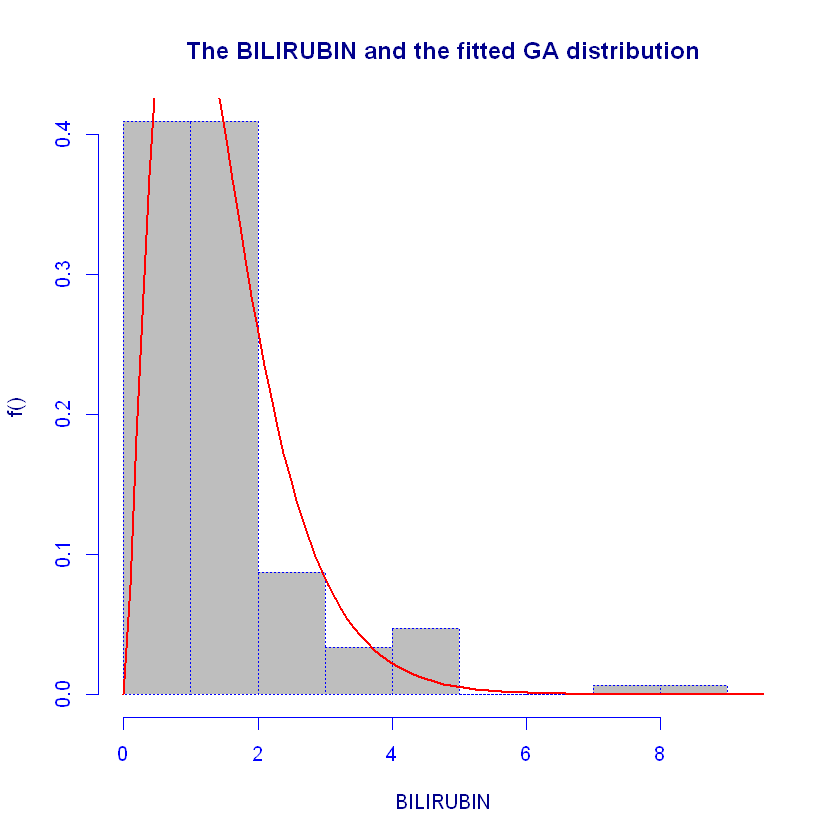

In [4]:
library(gamlss)

histDist(data=df,BILIRUBIN,family='GA')


Family:  c("NO", "Normal") 
Fitting method: "nlminb" 

Call:  gamlssML(formula = BILIRUBIN, family = "NO", data = df) 

Mu Coefficients:
[1]  1.428
Sigma Coefficients:
[1]  0.189

 Degrees of Freedom for the fit: 2 Residual Deg. of Freedom   147 
Global Deviance:     479.174 
            AIC:     483.174 
            SBC:     489.182 

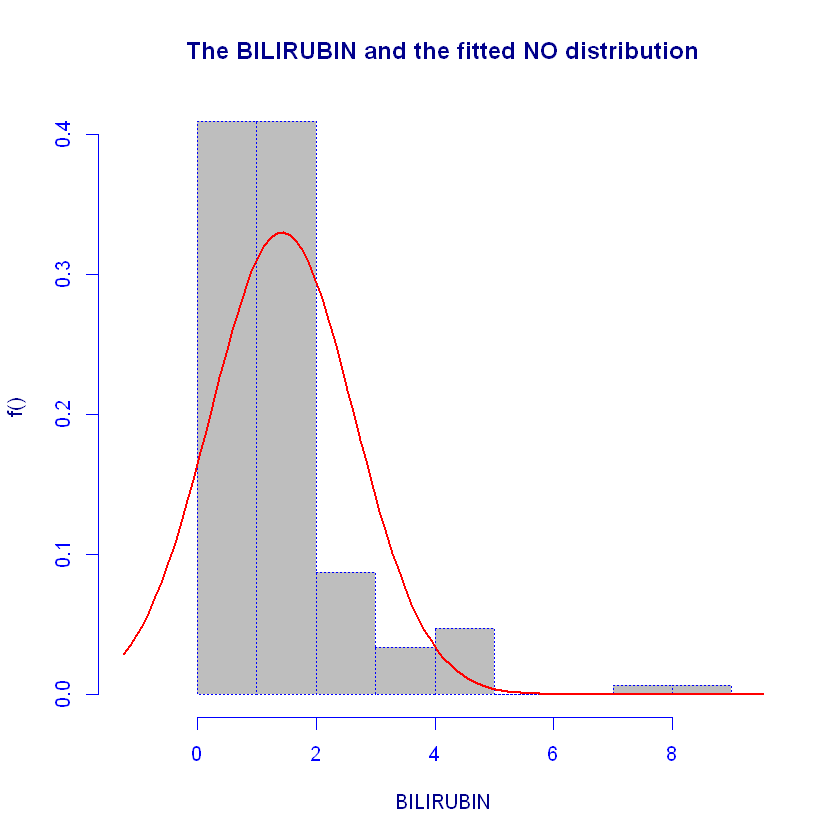

In [24]:
histDist(data=df,BILIRUBIN,family='NO')

Có nhiều cách định nghĩa phân phối Gamma, thông thường ta sử dụng 2 tham số là alpha (shape) và beta (scale), gói R cơ bản sử dụng cách định nghĩa này. Tuy nhiên trong gamlss, phân phối Gamma được xác định bằng cách khác, với 2 tham số là Mu và Sigma.

Hàm PDF của phân phối Gamma trong gamlss như sau:

$$f(y|\mu ,\sigma)=\frac{1}{\left ( \sigma ^{2} \mu \right )^{1/\sigma^{2}}}\frac{y^{\frac{1}{\sigma ^{2}}-1}e^{-y/(\sigma ^{2}\mu )}}{\Gamma \left ( 1/\sigma^{2} \right )}$$

gamlss cho phép dựng 2 mô hình riêng biệt cho 2 tham số: Mu và Sigma trong hàm PDF nêu trên. Liên hệ giữa Mu, Sigma và alpha, beta là như sau:

$$\mu = \alpha * \beta$$

Mu có ý nghĩa như vị trí trung tâm (trung bình) của biến kết quả cần ước lượng, Mu phụ thuộc cả vào alpha và beta.

Sigma có quan hệ với alpha:

$$\sigma = \sqrt{\frac{1}{\alpha }}$$

Một khi có mu và sigma, có thể ước tính độ lệch chuẩn và phương sai của Y:

$$SD = \sigma * \mu$$

Thí nghiệm mô phỏng sau đây sẽ cho phép hình dung về hiệu ứng lên mu và sigma khi thay đổi 2 tham số scale và shape :

Khi giữ nguyên shape = 10 và thay đổi scale ;

Warning message:
"`data_frame()` is deprecated, use `tibble()`.
This warning is displayed once per session."

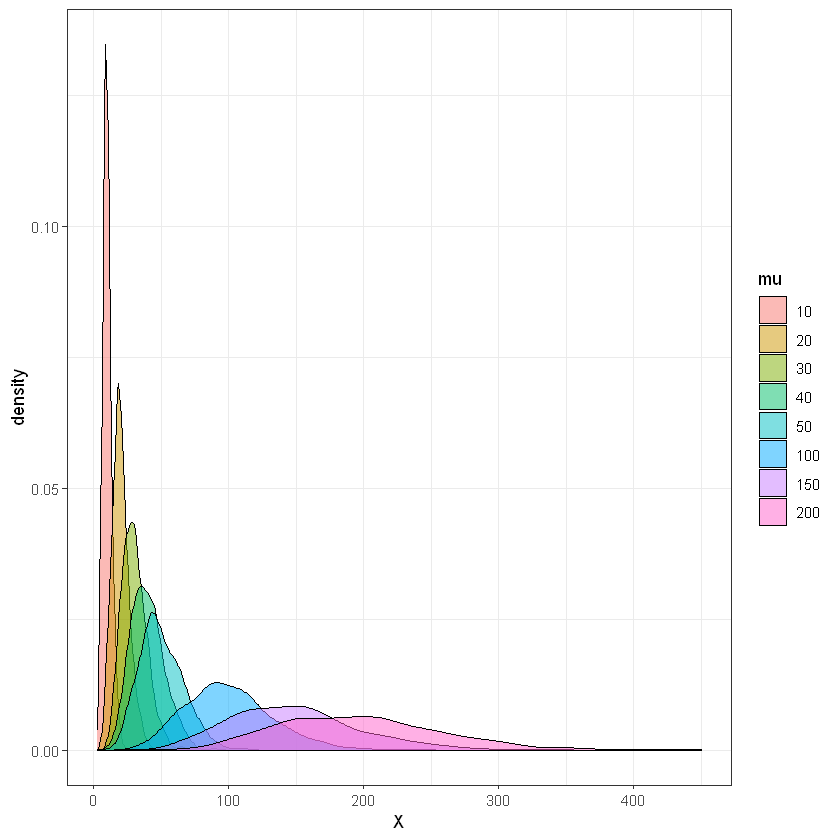

In [25]:
library(gamlss.dist)

sim_gamma = function(n,a,b){
  mu=a*b
  sigma=sqrt(1/a)
  sd=sigma*mu
  x = rGA(n,mu,sigma)
  return(x)
}

sim_df = data_frame(X=NA,shape=NA,scale=NA)

for (i in c(1,2,3,4,5,10,15,20)){
  x=sim_gamma(1000,10,i)
  temp_df = data_frame(X=x,shape=rep(10,1000),scale=rep(i,1000))
  sim_df = rbind(sim_df,temp_df)%>%na.omit()
}

sim_df$mu=factor(sim_df$shape*sim_df$scale)
sim_df%>%ggplot()+geom_density(aes(x=X,fill=mu),alpha=0.5)+theme_bw()

Như ta thấy trong hình, Gamma là một phân phối rất linh hoạt và phù hợp một cách tự nhiên với quy luật phân phối của nhiều đại lượng sinh học, với 2 đặc tính: liên tục trong tập hợp R+, và có kiểu hình biến chuyển đa dạng, từ lệch dương cho đến đối xứng.Hình ảnh này phụ thuộc vào tham số alpha (shape)và beta (scale.)

Khi giữ nguyên scale = 5 và thay đổi shape

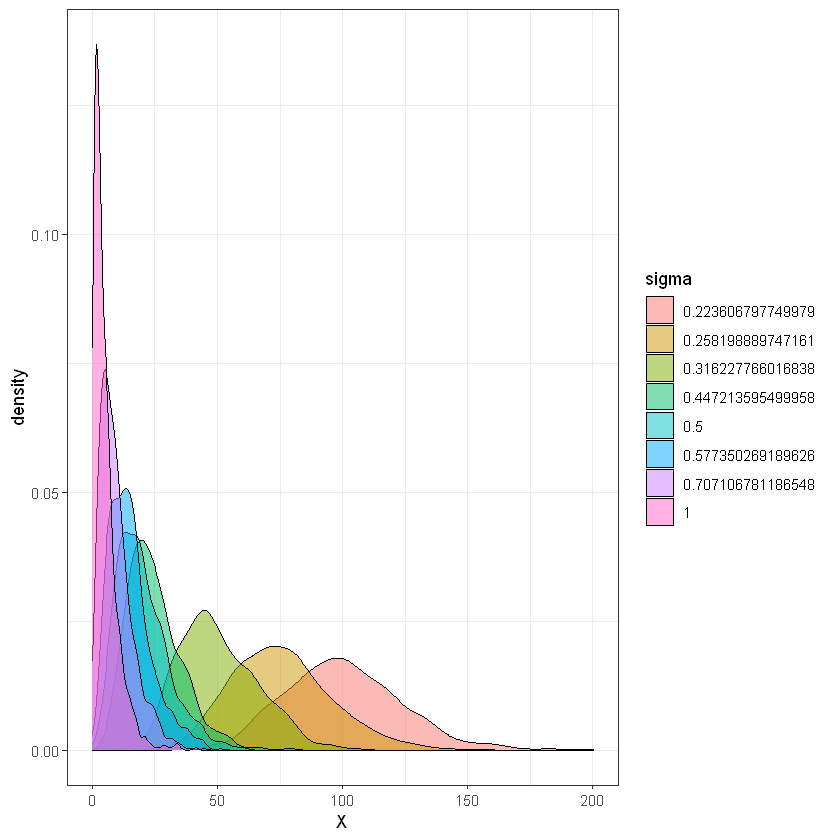

In [26]:
sim_df = data_frame(X=NA,shape=NA,scale=NA)

for (i in c(1,2,3,4,5,10,15,20)){
  x=sim_gamma(1000,i,5)
  temp_df = data_frame(X=x,shape=rep(i,1000),scale=rep(5,1000))
  sim_df = rbind(sim_df,temp_df)%>%na.omit()
}

sim_df$sigma=factor(sqrt(1/sim_df$shape))
sim_df%>%ggplot()+geom_density(aes(x=X,fill=sigma),alpha=0.5)+theme_bw()

Tương tác giữa scale và shape,

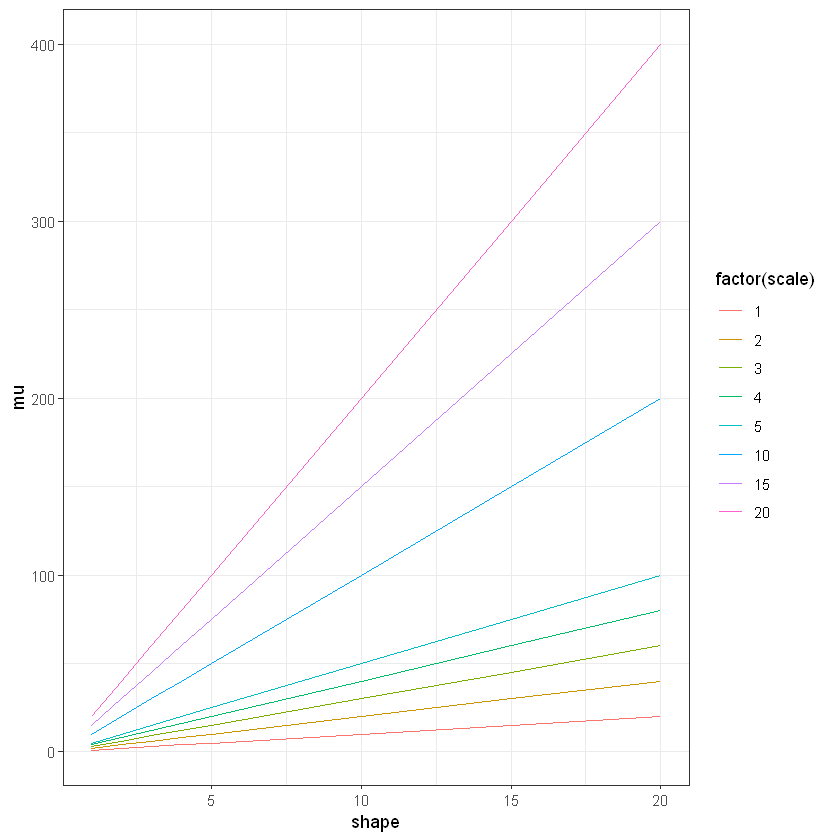

In [28]:
sim_df = data_frame(X=NA,shape=NA,scale=NA)

for (b in c(1,2,3,4,5,10,15,20)){
  for (a in c(1,2,3,4,5,10,15,20)){
       x=sim_gamma(1000,a,b)
       temp_df = data_frame(X=x,shape=rep(a,1000),scale=rep(b,1000))
  sim_df = rbind(sim_df,temp_df)%>%na.omit()
  }
}

sim_df$mu=sim_df$shape*sim_df$scale
sim_df$sigma=sqrt(1/sim_df$shape)
sim_df$sd=sim_df$mu*sim_df$sigma

sim_df%>%ggplot()+geom_path(aes(x=shape,y=mu,col=factor(scale)))+theme_bw()

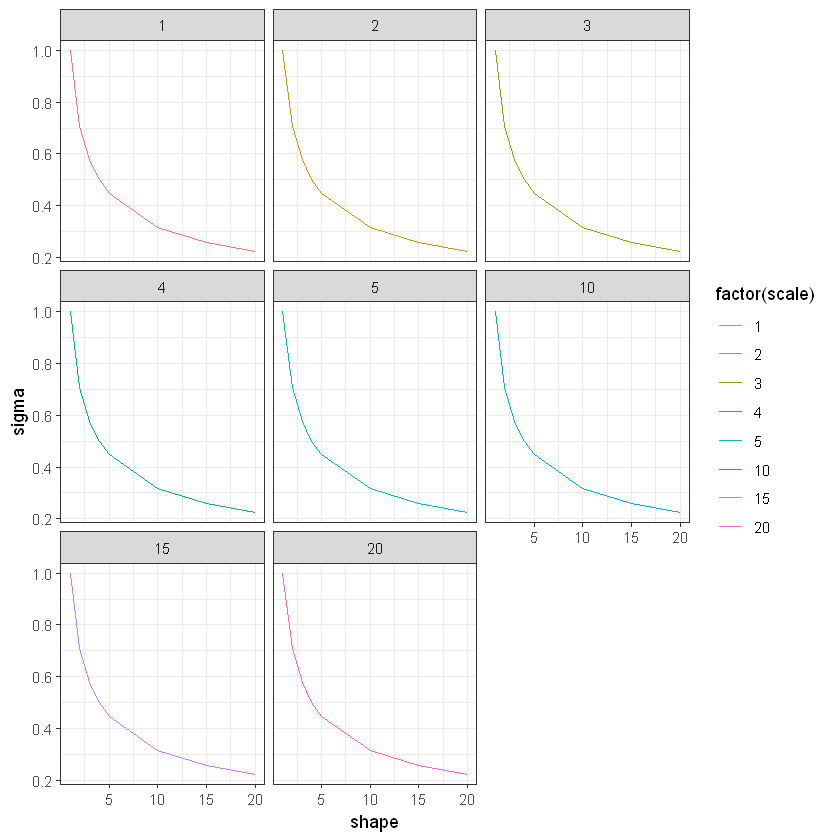

In [29]:
sim_df%>%ggplot()+geom_path(aes(x=shape,y=sigma,col=factor(scale)))+facet_wrap(~scale)+theme_bw()

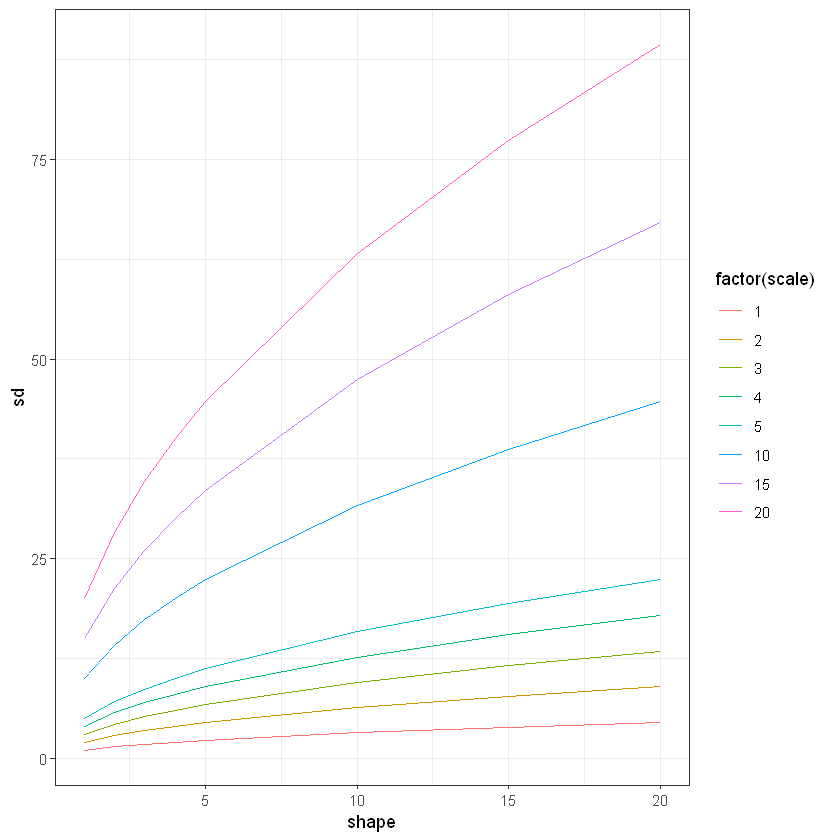

In [30]:
sim_df%>%ggplot()+geom_path(aes(x=shape,y=sd,col=factor(scale)))+theme_bw()

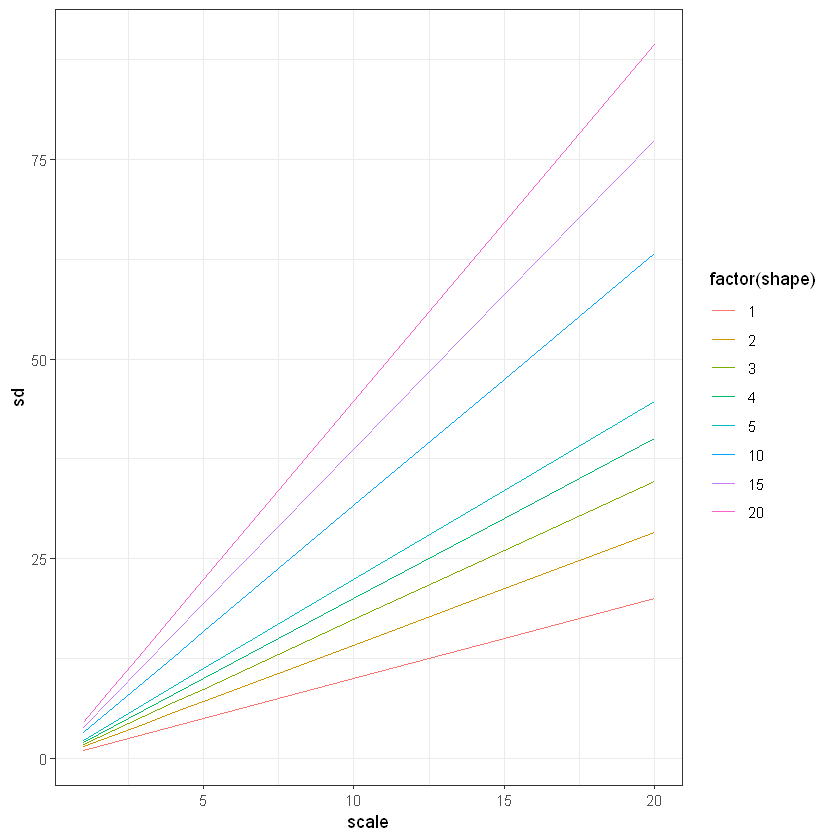

In [31]:
sim_df%>%ggplot()+geom_path(aes(x=scale,y=sd,col=factor(shape)))+theme_bw()

Bây giờ, Nhi dựng 2 mô hình hồi quy gamma với 2 tham số Mu và Sigma, cả 2 đều có link function (hàm liên kết) là log

In [5]:
library(broom)
library(sjPlot)

mod = gamlss(formula = BILIRUBIN ~ Class,
             data=df,
             sigma.fo = ~ Class,
             family = GA,
             trace=F,
       parallel="multicore",
       ncpus = nC)

summary(mod)

Warning message:
"package 'sjPlot' was built under R version 3.6.3"

******************************************************************
Family:  c("GA", "Gamma") 

Call:  gamlss(formula = BILIRUBIN ~ Class, sigma.formula = ~Class,  
    family = GA, data = df, trace = F, parallel = "multicore",      ncpus = nC) 


Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  log
Mu Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.13647    0.04497   3.034  0.00286 ** 
ClassG2_Die  0.79701    0.13717   5.810  3.8e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

------------------------------------------------------------------
Sigma link function:  log
Sigma Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.71214    0.06239 -11.414  < 2e-16 ***
ClassG2_Die  0.36933    0.13511   2.734  0.00704 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

--------------------------------------------------------

******************************************************************
	      Summary of the Quantile Residuals
                           mean   =  -0.00909365 
                       variance   =  1.003027 
               coef. of skewness  =  1.354485 
               coef. of kurtosis  =  5.463048 
Filliben correlation coefficient  =  0.9447688 
******************************************************************


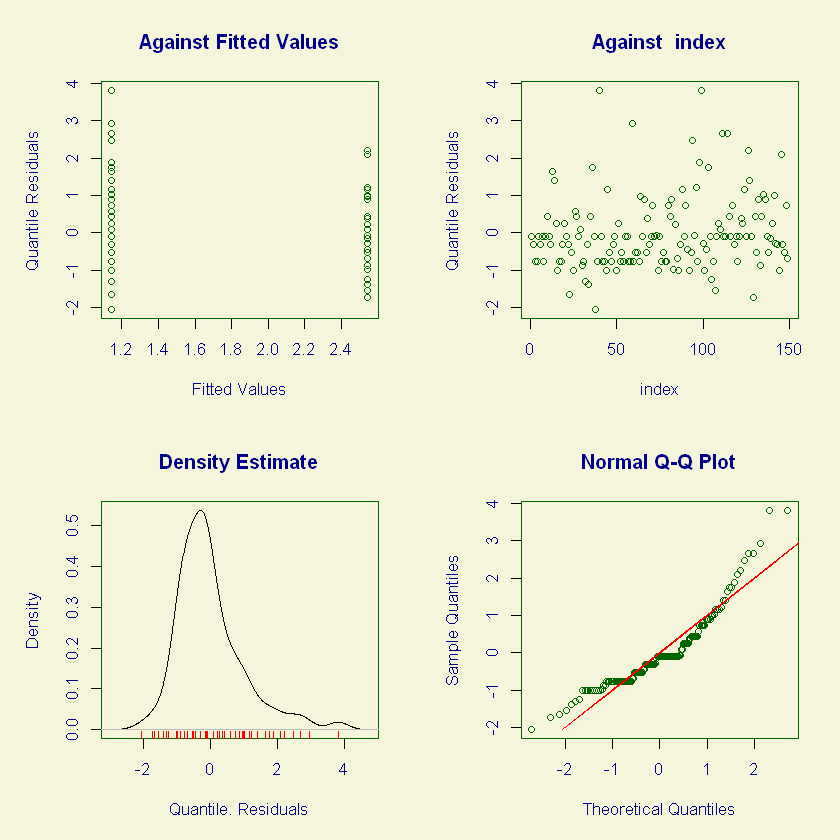

In [6]:
plot(mod)

Mô hình có AIC = 297.6 và BIC = 309.6, độ tự do sai số residual ở đây là 145; do chúng ta đã dùng 1 intercept và 1 phân nhóm G2 cho mỗi mô hình Mu và Sigma ((1+1)*2=4)

In [7]:
glance(mod)

df,logLik,AIC,BIC,deviance,df.residual
0,-144.8038,297.6076,309.6234,289.6076,145


Sử dụng hàm augment của package broom , ta có thể vẽ biểu đồ khảo sát “marginal effect” của mô hình: lưu ý rằng cần áp dụng hàm exponential trên các hiệu ứng gốc trong mô hình để quy đổi về thang đo nguyên thủy.

Khi mô hình trở nên phức tạp, biểu diễn nội dung của nó bằng biểu đồ là một cách để người đọc nắm bắt được thông tin trực quan và đơn giản.

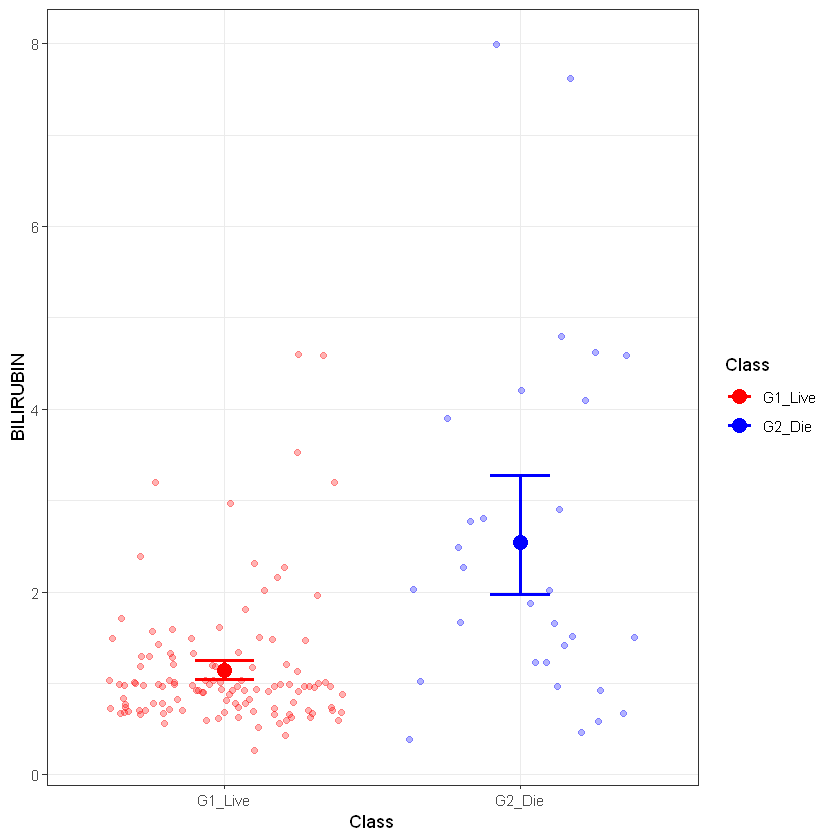

In [8]:
augment(mod)%>%mutate(UL= .fitted +.se.fit*1.96,
                      LL=.fitted-.se.fit*1.96)%>%
  ggplot()+
  geom_jitter(aes(x=Class,y=BILIRUBIN,col=Class),alpha=0.3)+
  geom_errorbar(aes(x=Class, ymin=exp(LL), ymax=exp(UL),col=Class),
                width=0.2, 
                size=1) + 
  geom_point(aes(x=Class, y=exp(.fitted),col=Class), 
             size=4) +
  geom_path(aes(x=Class, y=exp(.fitted)))+
  scale_color_manual(values=c("red","blue"))+
  theme_bw()  

Nội dung của mô hình có thể được diễn giải bằng các arithmetic mean ratio trên một biểu đồ, như đã bàn ở trên; lưu ý rằng mô hình gamlss cho phép suy diễn đồng thời hiệu ứng trên cả 2 tham số Mu (trung bình, vị trí trung tâm) và sigma (kiểu hình của phân bố).

Trong dữ liệu hiện thời, hiệu ứng của phân nhóm G1, G2 đều có ý nghĩa trong cả 2 tham số Mu và Sigma. Nói cách khác, khi bệnh viêm gan càng nặng (nguy cơ tử vong cao) thì bilirubin càng phân bố theo khuynh hướng: vị trí trung tâm dịch chuyển sang phải (tăng cao), nhưng sự phân tán cũng cao hơn và hình ảnh phân bố lệch nhiều hơn (skewness tăng).

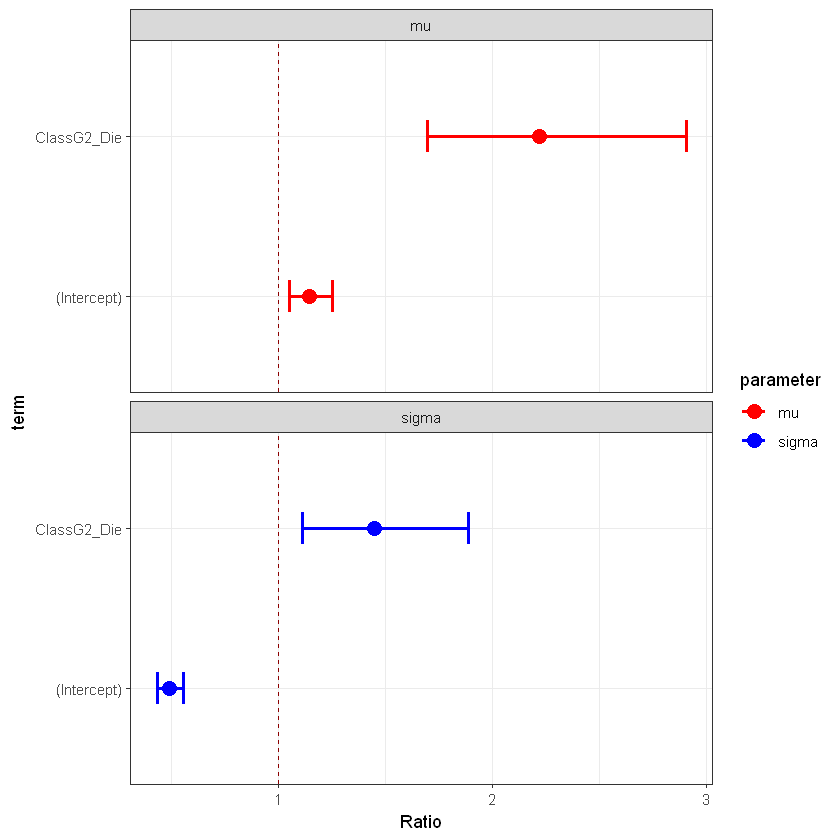

In [9]:
tidy(mod)%>%mutate(Ratio=exp(estimate),
                   LL=exp(estimate-1.96*std.error),
                   UL=exp(estimate+1.96*std.error))%>%
  ggplot()+
  geom_errorbar(aes(x=term, ymin=LL, ymax=UL,col=parameter),
                width=0.2, 
                size=1) + 
  geom_point(aes(x=term,y=Ratio,col=parameter), 
             size=4)+
  geom_hline(yintercept=1,linetype=2,col="red4")+
  coord_flip()+
  facet_wrap(~parameter,ncol=1)+
  scale_color_manual(values=c("red","blue"))+
  theme_bw()  

# Bootstrap mô hình gamlss

Ta sẽ nâng cao hơn 1 chút bằng một phân tích hồi quy bootstrap, Nhi dùng hàm bootstraps của package rsample để tạo ra 1000 phiên bản dữ liệu ngẫu nhiên khác nhau (có bảo tồn tỉ lệ 2 phân nhóm), sau đó dựng cùng một mô hình như trên cho mỗi phiên bản dữ liệu; trích xuất kết quả 1000 mô hình này.

Đây là dữ liệu kết quả của 1000 mô hình gamma:

In [11]:
library(rsample)

boot_df <- bootstraps(df, strata = "Class", times = 1000)

mu_form=as.formula(BILIRUBIN ~ Class)
sigma_form=as.formula(~ Class)

mod=df%>%gamlss(formula =.$BILIRUBIN ~ .$Class,
       sigma.fo = ~ .$Class,
       family = GA,
       trace=F,
       parallel="multicore",
       ncpus = nC)

model_dev = function(splits,...){
  mod = gamlss(..., data=analysis(splits),
               family = GA,
               trace=F,
               parallel="multicore",
               ncpus = nC)
  
  tidy_df=broom::tidy(mod,
              conf.int = TRUE, 
              conf.level = 0.975)
  
  glance_df = glance(mod)
  
  tidy_df<-tidy_df%>%mutate(BIC=glance_df$BIC,
                   AIC=glance_df$AIC,
                   R2=Rsq(mod))
  return(tidy_df)
  }

coef_list <- map(.x = boot_df$splits, 
             .f = model_dev, 
             mu_form,
             sigma_form)%>%
  map_df(~data_frame(Para=.x$parameter,
                     Term=.x$term,
                     Est=.x$estimate,
                     Ratio=exp(.x$estimate),
                     t=.x$statistic,
                     p_val=.x$p.value,
                     BIC=.x$BIC,
                     AIC=.x$AIC,
                     R2=.x$R2))

Warning message:
"package 'rsample' was built under R version 3.6.3"Warning message:
"`data_frame()` is deprecated as of tibble 1.1.0.
Please use `tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."

Picking joint bandwidth of 0.0425
Picking joint bandwidth of 0.0257


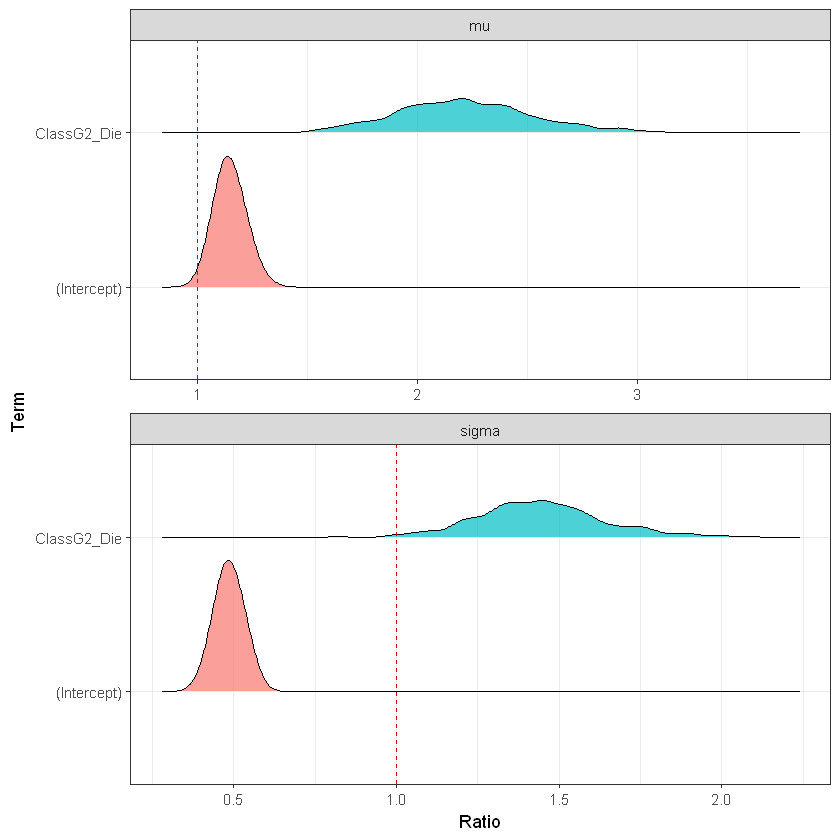

In [15]:
library(ggridges)

coef_list%>%
  ggplot(aes(y=Term,x=Ratio))+
  geom_density_ridges(alpha=0.7,scale=0.85,
                      aes(fill=Term),
                      show.legend = F)+
  scale_y_discrete(expand = c(0.1,0.5))+
  geom_vline(xintercept = 1,linetype=2,col="red3")+
  theme_bw()+
  facet_wrap(~Para,ncol=1,scales = "free")

Phân tích bootstrap cho phép ta ước tính khoảng tin cậy 97.5% cho tỉ số arithmetic mean ratio của phân nhóm G2 cho Mu, Sigma:

In [16]:
coef_list%>%
  group_by(Para,Term)%>%
    summarise_at("Ratio",funs(n=length(.),
                              Mean=mean,
                              Median=median,
                              LL=quantile(.,0.025),
                              UL=quantile(.,0.975),
                              Min=min,
                              Max=max))

Warning message:
"`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."

Para,Term,n,Mean,Median,LL,UL,Min,Max
mu,(Intercept),1000,1.146297,1.141176,1.0352521,1.2865756,0.9672269,1.3571429
mu,ClassG2_Die,1000,2.220263,2.203297,1.6388808,2.9185847,1.3088394,3.6082537
sigma,(Intercept),1000,0.485638,0.485592,0.4020525,0.5666852,0.3582704,0.6025751
sigma,ClassG2_Die,1000,1.443859,1.436207,1.0682039,1.8873851,0.7853665,2.1606540


Kết quả này khép lại bài thực hành, hy vọng các bạn đã có những giây phút học tập vui vẻ. Như bạn thấy, mô hình hồi quy là một công cụ hữu ích ; hẹn gặp các bạn trong một lần khác.